#### Basic Setup

In [221]:
import numpy as np
import pandas as pd
import wget
import sklearn.model_selection
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge

In [2]:
data = wget.download("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv")

Data prep

In [3]:
df = pd.read_csv(data)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
categories = ['latitude', 'longitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity']
df_features = df[categories]
df_features.head()

In [11]:
df_features = df_features.fillna(0)
df_features.isnull().sum()

latitude              0
longitude             0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [169]:
df_features['rooms_per_household'] = df['total_rooms'] / df['households']
df_features['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
df_features['population_per_household'] = df['population'] / df['households']
df_features = df_features.fillna(0)
df_features.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
0,37.88,-122.23,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,6.984127,0.146591,2.555556
1,37.86,-122.22,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,6.238137,0.155797,2.109842
2,37.85,-122.24,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,8.288136,0.129516,2.802260
3,37.85,-122.25,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,5.817352,0.184458,2.547945
4,37.85,-122.25,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,6.281853,0.172096,2.181467


#### Q1

In [170]:
df_features['ocean_proximity'].mode()

0    <1H OCEAN
Name: ocean_proximity, dtype: object

#### Splitting Data

In [171]:
df_train, df_testval = sklearn.model_selection.train_test_split(df_features, train_size=0.6, random_state=42)
df_val, df_test = sklearn.model_selection.train_test_split(df_testval, train_size=0.5, random_state=42)

target_train = df_train['median_house_value']
target_val = df_val['median_house_value']
target_test = df_test['median_house_value']

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

#### Q2

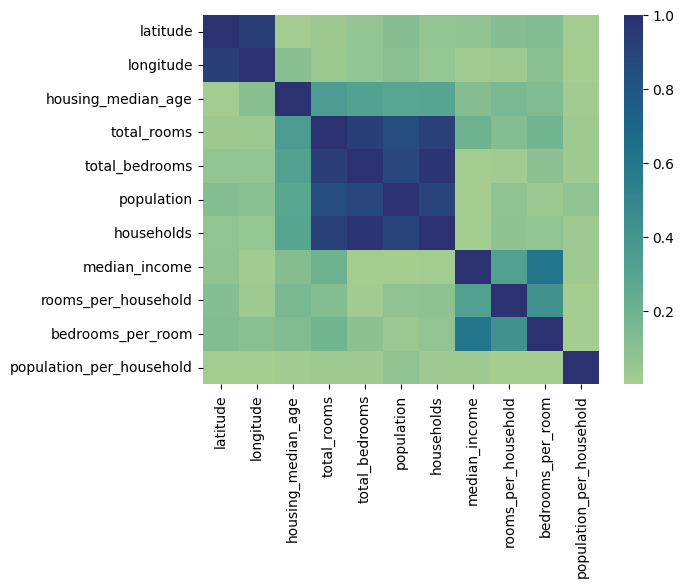

In [172]:
corr_matrix = df_train.corr()

sns.heatmap(corr_matrix.abs(), cmap="crest")
plt.show()

#### Binarizing median_house_value

In [173]:
def binarizer(df, mean):
    output = []
    for x in df:
        if x >= mean:
            output.append(1)
        else:
            output.append(0)
    return np.array(output)


In [174]:
target_train_mean = target_train.mean()
above_average = binarizer(target_train.values, target_train_mean)

#### Q3

In [175]:
scores = mutual_info_score(df_train['ocean_proximity'], above_average)
round(scores, 2)

0.1

#### Q4

In [185]:
# One-hot encoding
dv = DictVectorizer(sparse=False)

traind = df_train.to_dict(orient='records')

x_train = dv.fit_transform(traind)

vald = df_val.to_dict(orient='records')
x_val = dv.transform(vald)
y_val = binarizer(target_val, target_train_mean)

In [177]:
model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)
model.fit(x_train, above_average)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [193]:
y_pred = model.predict(x_val)
accuracy = (y_pred == y_val).mean().round(2)
accuracy

0.83

#### Q5

In [195]:
def one_hot_encoder(df, fit=True):
    df_dicts = df.to_dict(orient='records')
    if fit == False:
        return dv.transform(df_dicts)
    return dv.fit_transform(df_dicts)

In [205]:
model1 = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)
model2 = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)
model3 = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)
model4 = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)

# without total_rooms
vars1 = ['latitude', 'longitude', 'housing_median_age', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity', 'rooms_per_household', 'bedrooms_per_room', 'population_per_household']

# without total_bedrooms
vars2 = ['latitude', 'longitude', 'housing_median_age', 'total_rooms', 'population', 'households', 'median_income', 'ocean_proximity', 'rooms_per_household', 'bedrooms_per_room', 'population_per_household']

# without population
vars3 = ['latitude', 'longitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'households', 'median_income', 'ocean_proximity', 'rooms_per_household', 'bedrooms_per_room', 'population_per_household']

# without households
vars4 = ['latitude', 'longitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'median_income', 'ocean_proximity', 'rooms_per_household', 'bedrooms_per_room', 'population_per_household']

df_train1 = df_train[vars1]
df_train2 = df_train[vars2]
df_train3 = df_train[vars3]
df_train4 = df_train[vars4]

x_train1 = one_hot_encoder(df_train1)
x_train2 = one_hot_encoder(df_train2)
x_train3 = one_hot_encoder(df_train3)
x_train4 = one_hot_encoder(df_train4)

model1.fit(x_train1, above_average)
model2.fit(x_train2, above_average)
model3.fit(x_train3, above_average)
model4.fit(x_train4, above_average)


LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [210]:
val1 = df_val[vars1]
val2 = df_val[vars2]
val3 = df_val[vars3]
val4 = df_val[vars4]

x_val1 = one_hot_encoder(val1, fit=False)
x_val2 = one_hot_encoder(val2, fit=False)
x_val3 = one_hot_encoder(val3, fit=False)
x_val4 = one_hot_encoder(val4, fit=False)

In [217]:
pred1 = model1.predict(x_val1)
pred2 = model2.predict(x_val2)
pred3 = model3.predict(x_val3)
pred4 = model4.predict(x_val4)


accuracy1 = (pred1 == y_val).mean().round(2)
accuracy2 = (pred2 == y_val).mean().round(2)
accuracy3 = (pred3 == y_val).mean().round(2)
accuracy4 = (pred4 == y_val).mean().round(2)

accuracy, accuracy1, accuracy2, accuracy3, accuracy4

(0.83, 0.4, 0.4, 0.6, 0.82)

#### Q6

In [222]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [219]:
y_train_lin = np.log1p(target_train.values)
y_val_lin = np.log1p(target_val.values)

In [228]:
alphas = [0, 0.01, 0.1, 1, 10]
rmses = {}

for a in alphas:
    model = Ridge(alpha=a, solver="sag", random_state=42)
    model.fit(x_train, y_train_lin)

    y_pred = model.predict(x_val)
    rmses[a] = rmse(y_val_lin, y_pred).round(3)

rmses

{0: 0.546, 0.01: 0.546, 0.1: 0.546, 1: 0.546, 10: 0.546}